In [44]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

import joblib

file_name = "xa.s12.00.mhz.1974-07-11HR00_evid00152.csv"
processed_csv = "./data/lunar/data/training/data/Processed/xa.s12.00.mhz.1974-07-17HR00_evid00153.csv"

Categorizing Script

In [45]:
results_array = []

catalog_lunar_dir = "./data/lunar/data/training/catalogs/apollo12_catalog_GradeA_final.csv"

catalog_lunar = pd.read_csv(catalog_lunar_dir)

# Initialize an array to store results DataFrames for each catalog row
results_array = []

# Loop through each row in the catalog_lunar DataFrame
for index, row in catalog_lunar.iterrows():
    try:
    # Parse arrival time and relative arrival time
        arrival_time = datetime.strptime(row["time_abs(%Y-%m-%dT%H:%M:%S.%f)"], '%Y-%m-%dT%H:%M:%S.%f')
        arrival_time_relative = row["time_rel(sec)"]
        test_filename = row.filename
        data_dir = "./data/lunar/data/training/data/Processed/"
        csv_file = f'{data_dir}{test_filename}.csv'
        
        # Load the raw data from the corresponding CSV file
        raw_data = pd.read_csv(csv_file)

        chunk_size = 10000
        total_rows = raw_data.shape[0]

        # Create a DataFrame to hold results for the current row
        results_df = pd.DataFrame(columns=["chunk", "label"])

        # Process the raw data in chunks
        for start in range(0, total_rows, chunk_size):
            end = start + chunk_size

            chunk = raw_data.iloc[start:end]
            data_df = pd.DataFrame(chunk["time_rel(sec)"])
        
            # Categorize based on arrival time
            if arrival_time_relative < data_df["time_rel(sec)"].values.max() and arrival_time_relative > data_df["time_rel(sec)"].values.min():
                new_row = pd.DataFrame({"chunk": [chunk], "label": [1]})
            else:
                new_row = pd.DataFrame({"chunk": [chunk], "label": [0]})

            # Append new row to results DataFrame
            results_df = pd.concat([results_df, new_row], ignore_index=True)

        # Append the results DataFrame to the results array
        results_array.append(results_df)
    except FileNotFoundError:
        print(f"File not found for test filename: {test_filename}. Skipping this entry.")

File not found for test filename: xa.s12.00.mhz.1971-04-13HR00_evid00029. Skipping this entry.


In [46]:
testing_df = pd.concat(results_array, ignore_index=True)

In [47]:
label_counts = testing_df["label"].value_counts()

count_label_1 = label_counts.get(1, 0)

count_label_1

np.int64(75)

In [48]:
# Hold chunks and labels
X = []
y = []

for index, row in testing_df.iterrows():
    # Convert chunk to DataFrame and select the "time_rel(sec)" column
    chunk_data = row["chunk"]["time_rel(sec)"].to_numpy()

    # Ensure chunk_data is numeric, ignore non-numeric values
    chunk_data = pd.to_numeric(chunk_data, errors='coerce')

    # Extract features from chunk_data
    features = [
        np.nanmean(chunk_data),  # Mean of time_rel(sec), ignoring NaNs
        np.nanstd(chunk_data),   # Standard deviation, ignoring NaNs
        np.nanmin(chunk_data),   # Minimum value, ignoring NaNs
        np.nanmax(chunk_data),   # Maximum value, ignoring NaNs
    ]

    X.append(features)  # Append features
    y.append(row["label"])  # Append label

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

With RandomForest

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a RandomForest classifier
clf = RandomForestClassifier()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")

Model accuracy: 0.99


With LogisticRegression

In [50]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# smote = SMOTE(random_state=42)

# # Apply SMOTE to the training data
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize the Random Forest Classifier model
rf_classifier = RandomForestClassifier(class_weight="balanced", random_state=42)

# Train the model on the resampled data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(f"Model accuracy: {accuracy:.2f}")
print(y_pred)

              precision    recall  f1-score   support

           0       0.99      0.76      0.86       856
           1       0.01      0.20      0.02        10

    accuracy                           0.75       866
   macro avg       0.50      0.48      0.44       866
weighted avg       0.98      0.75      0.85       866

Model accuracy: 0.75
[1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0
 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 1 1 1 1 0
 0 1 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1
 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0

In [51]:
predictions = rf_classifier.predict(X_test)
print(predictions)

[1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0
 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 1 1 1 1 0
 0 1 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1
 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0
 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1
 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 1
 0 0 0 1 0 0 0 0 1 0 0 0 

Testing the Model

In [52]:
joblib.dump(rf_classifier, "RF-QuakeModel.pkl")

raw_data_testing = pd.read_csv(processed_csv)

model_path = "RF-QuakeModel.pkl"

model = joblib.load(model_path)

print("model loaded successfully")


model loaded successfully


In [53]:
chunk_size = 10000
total_rows = raw_data_testing.shape[0]

results_chunks = []

In [54]:
chunk = raw_data_testing[10000:20000]
chunk_data = chunk["time_rel(sec)"].to_numpy()
chunk_data

array([1509.43396226, 1509.58490566, 1509.73584906, ..., 3018.41509434,
       3018.56603774, 3018.71698113])

[10566.03773584906, 10566.18867924528, 10566.33962264151, 10566.49056603774, 10566.64150943396, 10566.79245283019, 10566.94339622642, 10567.09433962264, 10567.24528301887, 10567.39622641509, 10567.54716981132, 10567.69811320755, 10567.84905660377, 10568.0, 10568.15094339623, 10568.30188679245, 10568.45283018868, 10568.60377358491, 10568.75471698113, 10568.90566037736, 10569.05660377358, 10569.20754716981, 10569.35849056604, 10569.50943396226, 10569.66037735849, 10569.81132075472, 10569.96226415094, 10570.11320754717, 10570.2641509434, 10570.41509433962, 10570.56603773585, 10570.71698113207, 10570.8679245283, 10571.01886792453, 10571.16981132075, 10571.32075471698, 10571.47169811321, 10571.62264150943, 10571.77358490566, 10571.92452830189, 10572.07547169811, 10572.22641509434, 10572.37735849057, 10572.52830188679, 10572.67924528302, 10572.83018867925, 10572.98113207547, 10573.1320754717, 10573.28301886793, 10573.43396226415, 10573.58490566038, 10573.7358490566, 10573.88679245283, 10574.

[       time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
 70000                            1974   10566.037736            0.0
 70001                            1974   10566.188679            0.0
 70002                            1974   10566.339623            0.0
 70003                            1974   10566.490566            0.0
 70004                            1974   10566.641509            0.0
 ...                               ...            ...            ...
 79995                            1974   12074.716981            0.0
 79996                            1974   12074.867925            0.0
 79997                            1974   12075.018868            0.0
 79998                            1974   12075.169811            0.0
 79999                            1974   12075.320755            0.0
 
 [10000 rows x 3 columns],
         time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
 300000                            1974   45283.018868  -1.117852e-09
 30

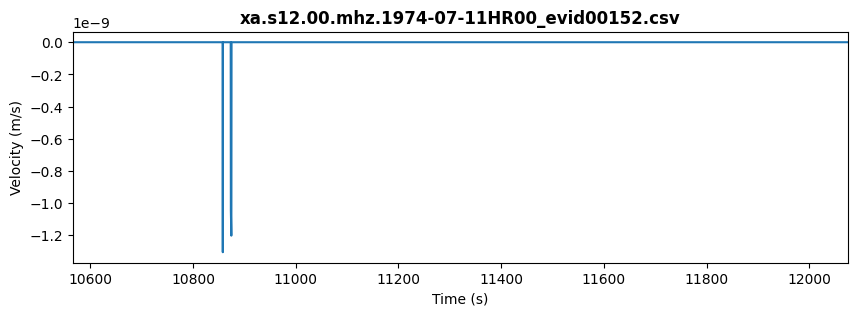

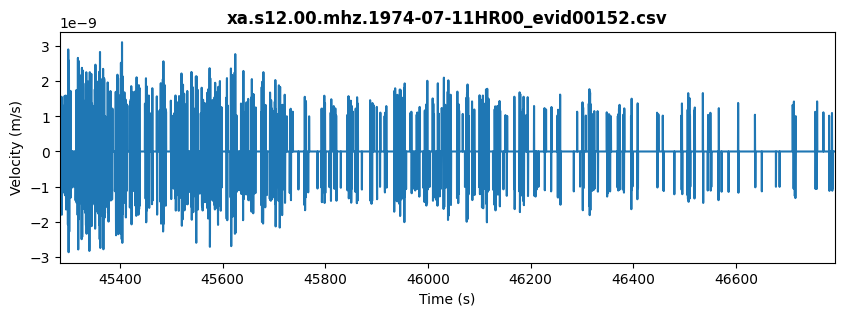

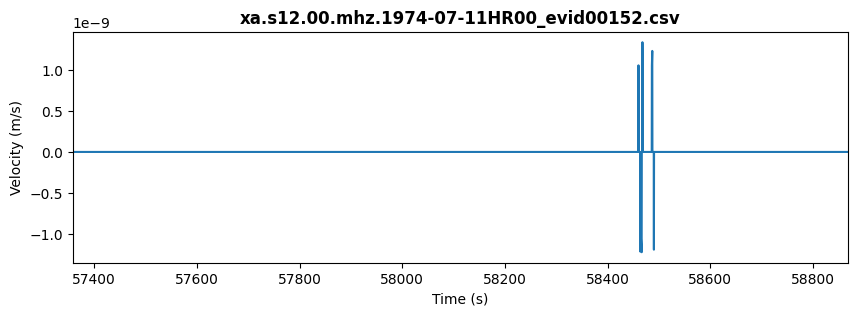

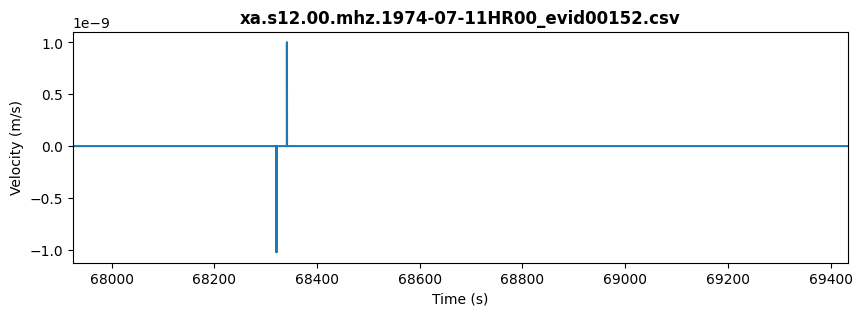

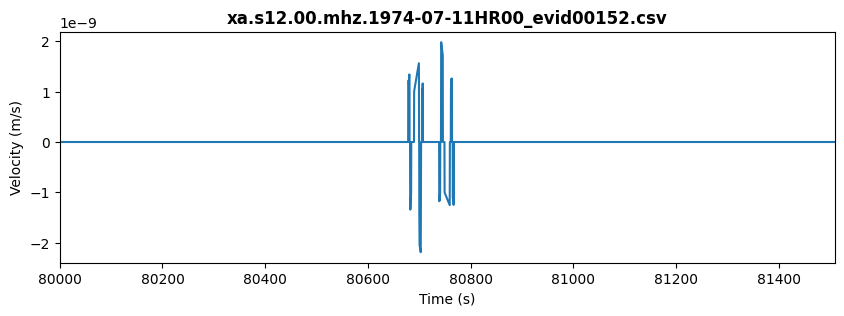

In [55]:
for start in range(0, total_rows, chunk_size):
    end = start + chunk_size
    chunk = raw_data_testing.iloc[start:end]

    chunk_data = chunk["time_rel(sec)"].to_numpy()
    chunk_data = pd.to_numeric(chunk_data, errors="coerce")

    features = [
        np.nanmean(chunk_data),  # Mean of time_rel(sec), ignoring NaNs
        np.nanstd(chunk_data),   # Standard deviation, ignoring NaNs
        np.nanmin(chunk_data),   # Minimum value, ignoring NaNs
        np.nanmax(chunk_data),   # Maximum value, ignoring NaNs
    ]

    features = np.array(features).reshape(1, -1)

    prediction = model.predict(features)
    

    if prediction[0] == 1:
        if (sum(chunk["velocity(m/s)"]) != 0):
            results_chunks.append(chunk)
            print (chunk["time_rel(sec)"].tolist())

            csv_times = np.array(chunk["time_rel(sec)"].tolist())
            csv_velocity = np.array(chunk["velocity(m/s)"].tolist())

            # Plot the trace!
            fig,ax = plt.subplots(1,1,figsize=(10,3))
            ax.plot(csv_times,csv_velocity)
            # Make the plot pretty
            ax.set_xlim([min(csv_times),max(csv_times)])
            ax.set_ylabel('Velocity (m/s)')
            ax.set_xlabel('Time (s)')
            ax.set_title(file_name, fontweight='bold')
results_chunks


In [56]:
if results_chunks:
    quake_chunks_def = pd.concat(results_chunks, ignore_index=True)
    print("Chunks containing earthquakes identified:")
    print(quake_chunks_def)
    print("res")
else:
    print("no quakes found")

with open("results_chunks.txt", "w") as file:
    for item in results_chunks:
        file.write(str(item) + "\n")

Chunks containing earthquakes identified:
       time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)  velocity(m/s)
0                                1974   10566.037736            0.0
1                                1974   10566.188679            0.0
2                                1974   10566.339623            0.0
3                                1974   10566.490566            0.0
4                                1974   10566.641509            0.0
...                               ...            ...            ...
49995                            1974   81508.679245            0.0
49996                            1974   81508.830189            0.0
49997                            1974   81508.981132            0.0
49998                            1974   81509.132075            0.0
49999                            1974   81509.283019            0.0

[50000 rows x 3 columns]
res


45081
80766.94339622642


Text(0.5, 1.0, 'xa.s12.00.mhz.1974-07-11HR00_evid00152.csv')

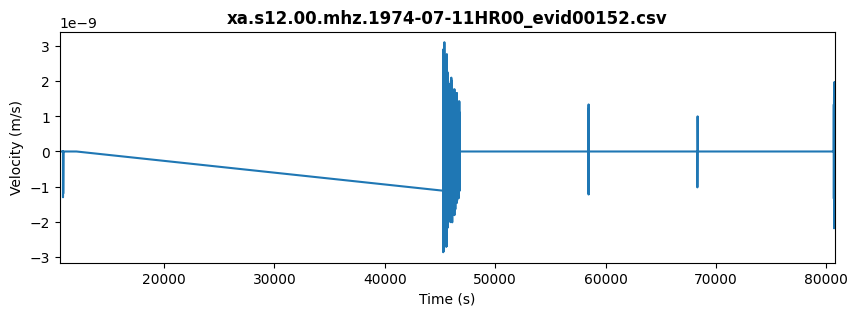

In [57]:
quakes = pd.concat(results_chunks, ignore_index=True)

csv_times = np.array(quakes["time_rel(sec)"].tolist() )
csv_velocity = np.array(quakes["velocity(m/s)"].tolist())

threshold = 1e-9

non_zero_indices = np.nonzero(np.abs(csv_velocity) > threshold)[-1]
# print(np.nonzero(csv_velocity))

if len(non_zero_indices) > 0:
    non_zero_index = non_zero_indices[-1]
else:
    non_zero_index = len(csv_velocity) - 1
print(non_zero_index)
trimmed_times = csv_times[:non_zero_index + 1]
trimmed_velocity = csv_velocity[:non_zero_index + 1]

# Plot the trace!
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(trimmed_times,trimmed_velocity)
# Make the plot pretty

ax.set_xlim([min(trimmed_times),max(trimmed_times)])
print(max(trimmed_times))
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(file_name, fontweight='bold')

In [58]:


data_catalog = pd.read_csv(processed_csv)
data_catalog

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1974,0.000000,0.0
1,1974,0.150943,0.0
2,1974,0.301887,0.0
3,1974,0.452830,0.0
4,1974,0.603774,0.0
...,...,...,...
572418,1974,86402.716981,0.0
572419,1974,86402.867925,0.0
572420,1974,86403.018868,0.0
572421,1974,86403.169811,0.0


xa.s12.00.mhz.1974-07-11HR00_evid00152


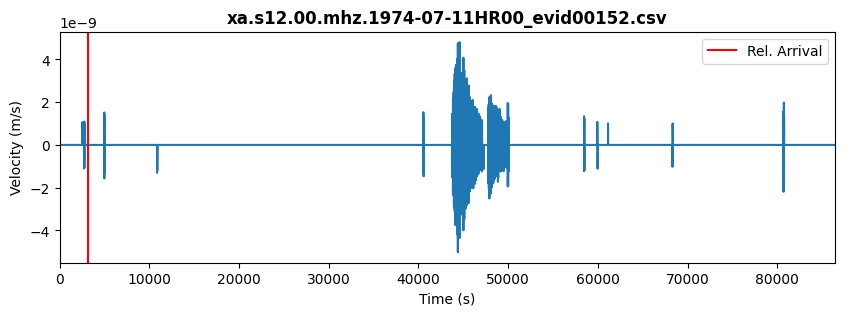

In [59]:
csv_times = np.array(data_catalog["time_rel(sec)"].tolist())
csv_velocity = np.array(data_catalog["velocity(m/s)"].tolist())

# Plot the trace!
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_velocity)
# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(file_name, fontweight='bold')
# Plot where the arrival time is
cat_directory = './data/lunar/data/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

row = cat.iloc[69]
test_filename = row.filename
print (test_filename)
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')

arrival_time_relative = row['time_rel(sec)']
arrival_line = ax.axvline(x=arrival_time_relative, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])